# Imports and data loading

In [1]:
# pip install git+https://github.com/raghakot/keras-vis.git -U

In [0]:
from keras.layers import Flatten, Dense, Input, Lambda, Dropout
from keras.models import Model

from keras.utils import to_categorical

from keras.applications import DenseNet121, VGG16

from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from vis.visualization import visualize_saliency, overlay, visualize_activation
from vis.utils import utils
from keras import activations

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
import numpy as np
train_images_fname = 'db_train.raw'
train_labels_fname = 'label_2019_train.txt'
test_images_fname = 'db_test.raw'


# number of images
num_train_images = 116157

# size of the images 56*56 pixels in gray levels
image_dim = 56 * 56 * 3

train_images_label = np.loadtxt(train_labels_fname, dtype=np.uint8)

with open(train_images_fname, 'rb') as f:
    train_images_data = np.fromfile(f, dtype=np.uint8).astype(np.float32)
with open(test_images_fname, 'rb') as f:
    test_images_data = np.fromfile(f, dtype=np.uint8).astype(np.float32)

In [0]:
train_images_data /= 255

test_images_data /= 255

# First plot

A first important step is to try to identify differences between label 1 and 0. If we do this, we will be able to tune our architecture, find pretrained model etc...

In [0]:
def plot_gallery(images,label=None, n_row=4, n_col=8, title= 'gallery',index=0, mycmap=plt.cm.gray, image_shape = (56, 56,3), size_coef=1):
    n_components = n_row * n_col
    if index=='r':
        index = np.random.choice(range(len(images)))-n_components
    images = images[index:n_components+index]
    """Plot images as gallery"""
    plt.figure(figsize=(1.8 * size_coef*n_col, 2.26 *size_coef* n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        ax = plt.subplot(n_row, n_col, i + 1)
        try:
          ax.set_title("{}".format(label[i+index]))
        except:
          pass
        comp = comp.reshape(image_shape)
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp < 0)
        if len(dmy[0]) > 0:
            yz, xz = dmy
        comp[comp < 0] = 0

        plt.imshow(comp, cmap=mycmap, vmax=vmax, vmin=vmin)

        if len(dmy[0]) > 0:
            plt.plot(xz, yz, 'r,', hold=True)
            print(len(dmy[0]), "negative-valued pixels")

        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()

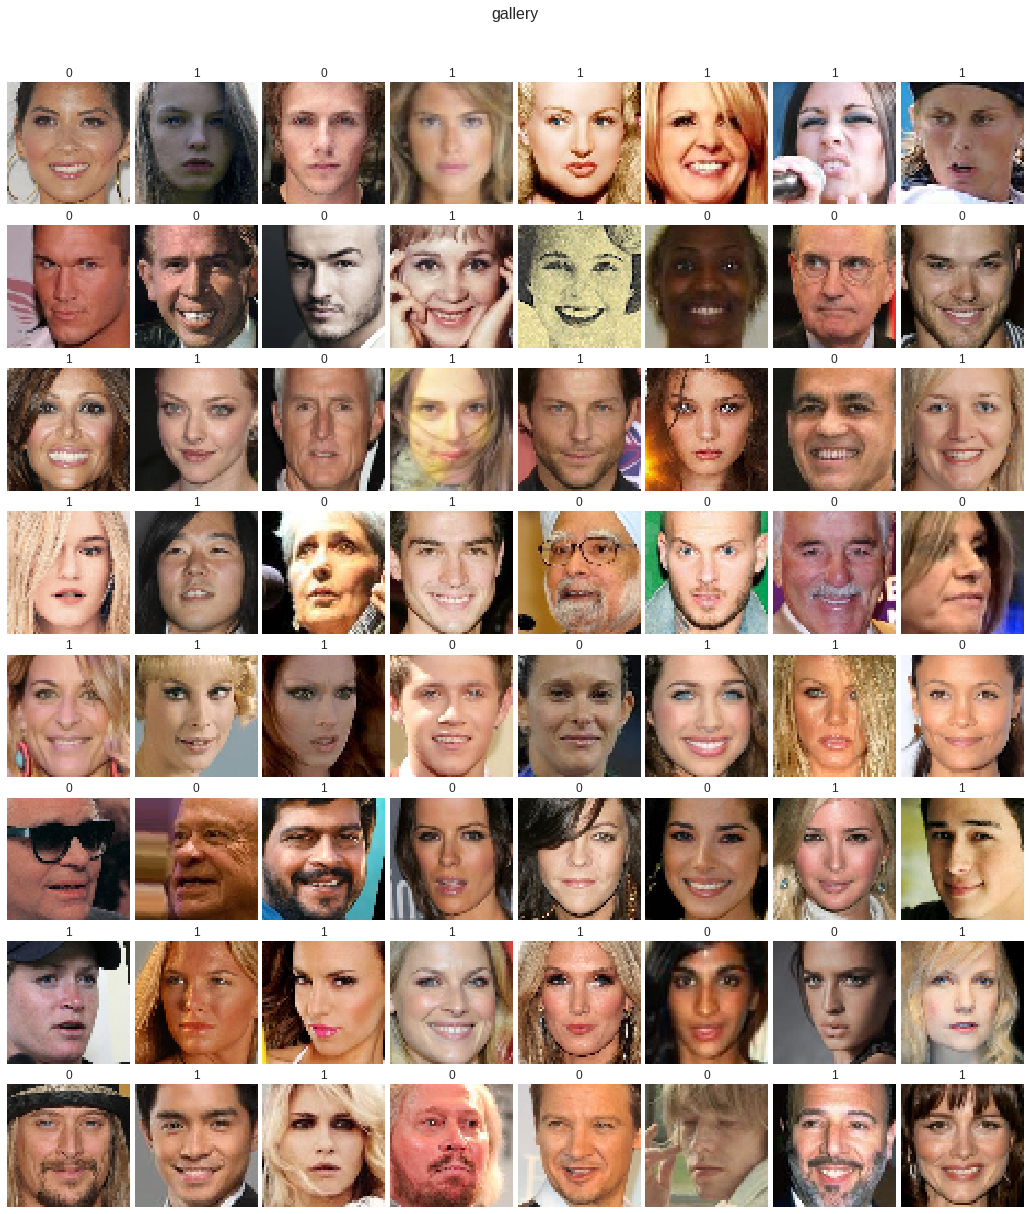

In [0]:
plot_gallery(train_images_data.reshape(-1,56*56*3), np.argmax(pred, axis=1), n_row=8, index='r')

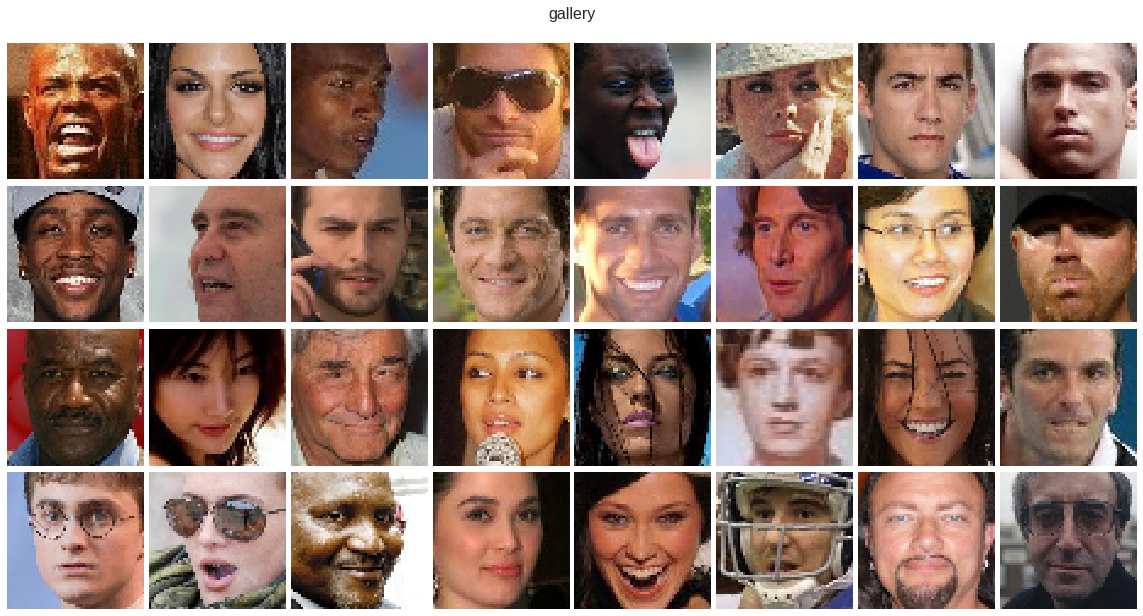

In [0]:
l = np.random.choice(range(len(train_images_data)), 200)
plot_gallery(train_images_data[l][train_images_label[l]==0])

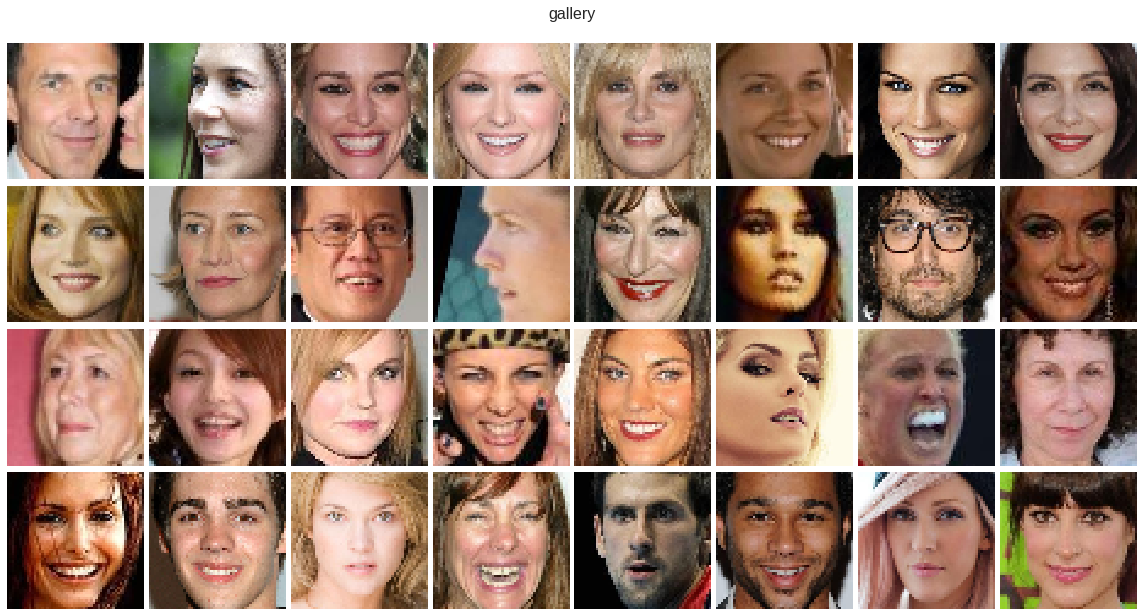

In [0]:
l = np.random.choice(range(len(train_images_data)), 200)
plot_gallery(train_images_data[l][train_images_label[l]==1])

Nothing trivial appear: men/women, glasses/no glasses, smile/neutral ... appears in both label. Plotting many images, I encounter some funny photos which caught my attention:

<img src="oeil.png" title="Title text" />
<img src="moussearaser.png" title="Title text" />

I first think that this was fake photo, maybe generated by a GAN? But I make a google image search and find the original image for the 2nd one.

<img src="img_search.jpg" title="Title text" />

One more time I was able to find both 0 and 1 images in internet. My last hypothesis was that some images have been attacked to fool a neural network. It would make it impossible to detect them to the naked eye. This is not helping me for the rest of the work.

# First model

I first define my new metric allowing to taking into account the fact that the dataset is unbalanced. In fact that wasn't necessary as i discovered later that the class_weight parameter was doing the same thing. I also realized that the validation_dataset was in the training dataset, that's why i didn't load it into memory. I simply used validation_split parameter.

In [0]:
labels = to_categorical(train_images_label)

In [0]:
from keras import backend as K
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def my_metric(y_true, y_pred):
    y_true=y_true[:,1]
    y_pred=y_pred[:,1]
    return 1/2*(specificity(y_true, y_pred)+sensitivity(y_true,y_pred))

I first try to implement transfer learning using a pretrained model on faces. I find [this repository](https://github.com/rcmalli/keras-vggface). I try different things including changing the last pooling layer, the input size etc. Indeed the model was trained on (224,224,3) images while our images are (56,56,3).

In [ ]:
img_inputs = Input(shape=(56*56*3,))
img_reshape = Reshape([56,56,3])(img_inputs)
img_resized = Lambda(lambda x : resize_images(x,[224,224],
    align_corners = True, # possibly important
    preserve_aspect_ratio = True))(img_reshape)
resize_model = Model(inputs=img_inputs, outputs=img_resized)

In [ ]:
nb_class = 2
hidden_dim = 512
vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
last_layer = vgg_model.get_layer('pool3').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, out)
final_model = Model(inputs = resize_model.input, outputs = custom_vgg_model(resize_model.output))

Unfortunately the pretrained weights never helped and a randomly initialized network learn as the pretrained one. That's why i give up the idea of transfer learning and try new architecture. The densenet allow me to achieve my best score.

In [0]:
nb_class = 2
hidden_dim = 512
dense_model = DenseNet121(weights='imagenet',include_top=False, input_shape=(56, 56, 3))
last_layer = dense_model.output
x = Flatten(name='flatten')(last_layer)
# x = Dropout(0.5)(x)
# x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dropout(0.5)(x)
x = Dense(hidden_dim//4, activation='relu', name='fc7')(x)
x = Dropout(0.5)(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
dense_f_model = Model(dense_model.input, out)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
dense_f_model.load_weights('dense_net')

For the test data, i reuse my pretrained network and in order to use the maximum of data I delete the validation_split and train only one last epoch.

In [0]:
# earlystop = EarlyStopping(monitor='my_metric', min_delta=0.001, patience=3, \
#                           verbose=1, mode='auto')
# callbacks_list = [earlystop]
dense_f_model.compile(Adam(lr=0.001), 'binary_crossentropy', metrics=[my_metric])
dense_f_model.fit(train_images_data.reshape(-1,56,56,3), labels, batch_size=512, epochs=1)#, callbacks=callbacks_list)

Epoch 1/1
116157/116157 [==============================] - 272s 2ms/step - loss: 0.2854 - my_metric: 0.8684


In [0]:
dense_f_model.save_weights('dense_net')

In [0]:
pred = dense_f_model.predict(test_images_data.reshape(-1,56,56,3))

In [0]:
np.savetxt("test_pred3.txt", np.argmax(pred, axis=1), fmt="%d")

I also try some data augmentation but that didn't help a lot except flipping

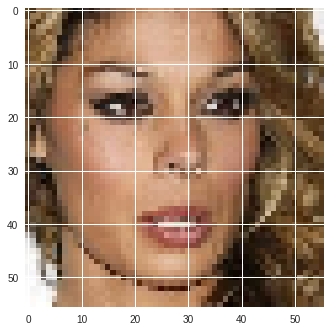

In [0]:
plt.imshow(train_images_data.reshape(-1,56,56,3)[0])

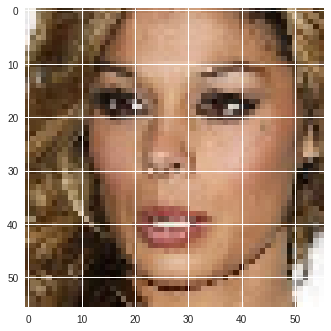

In [0]:
plt.imshow(np.flip(train_images_data.reshape(-1,56,56,3), axis=2)[0])

# Visualizing network

In order to try to find difference between 0 and 1, I make a bit more visualization. Using [keras-vis](https://github.com/raghakot/keras-vis), I plot the image which maximizes the prediction probability to belong to a class. There are many parameters i try to play with as input_range and input_modifiers.

In [0]:
dense_f_model.compile(Adam(lr=0.001), 'binary_crossentropy', metrics=['accuracy'])


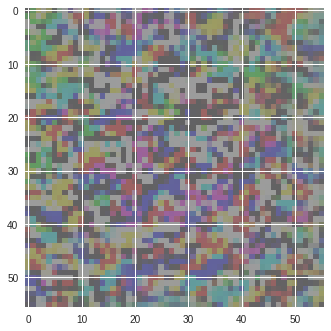

In [0]:
# layer_idx = utils.find_layer_idx(dense_f_model, 'preds')
layer_idx = -1
# Swap softmax with linear
dense_f_model.layers[layer_idx].activation = activations.linear
dense_f_model = utils.apply_modifications(dense_f_model)

# This is the output node we want to maximize.
filter_idx = 0
img0 = visualize_activation(dense_f_model, layer_idx, filter_indices=filter_idx,input_range=(0., 1.))
plt.imshow(img0)

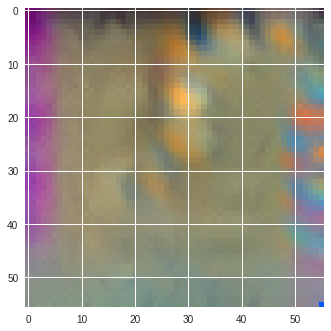

In [0]:
# layer_idx = utils.find_layer_idx(dense_f_model, 'preds')
layer_idx = -1
# Swap softmax with linear
dense_f_model.layers[layer_idx].activation = activations.linear
dense_f_model = utils.apply_modifications(dense_f_model)

# This is the output node we want to maximize.
filter_idx = 0
img0 = visualize_activation(dense_f_model, layer_idx, filter_indices=filter_idx)
plt.imshow(img0)

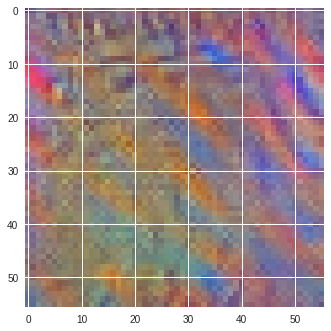

In [0]:
from vis.input_modifiers import Jitter

# layer_idx = utils.find_layer_idx(dense_f_model, 'preds')
layer_idx = -1
# Swap softmax with linear
dense_f_model.layers[layer_idx].activation = activations.linear
dense_f_model = utils.apply_modifications(dense_f_model)

# This is the output node we want to maximize.
filter_idx = 1
img1 = visualize_activation(dense_f_model, layer_idx, filter_indices=filter_idx, max_iter=500, input_modifiers=[Jitter(16)], verbose=True)
plt.imshow(img1)

Iteration: 1, named_losses: [('ActivationMax Loss', 6278.684),
 ('L-6.0 Norm Loss', 0.6374615),
 ('TV(2.0) Loss', 6316.194)], overall loss: 12595.515625
Iteration: 2, named_losses: [('ActivationMax Loss', 5226.5664),
 ('L-6.0 Norm Loss', 0.63324267),
 ('TV(2.0) Loss', 3974.1597)], overall loss: 9201.359375
Iteration: 3, named_losses: [('ActivationMax Loss', 4376.12),
 ('L-6.0 Norm Loss', 0.6301119),
 ('TV(2.0) Loss', 2690.7053)], overall loss: 7067.455078125
Iteration: 4, named_losses: [('ActivationMax Loss', 4063.6492),
 ('L-6.0 Norm Loss', 0.62806267),
 ('TV(2.0) Loss', 1851.9845)], overall loss: 5916.26171875
Iteration: 5, named_losses: [('ActivationMax Loss', 4007.1548),
 ('L-6.0 Norm Loss', 0.6268526),
 ('TV(2.0) Loss', 1360.4005)], overall loss: 5368.18212890625
Iteration: 6, named_losses: [('ActivationMax Loss', 3512.2002),
 ('L-6.0 Norm Loss', 0.6260788),
 ('TV(2.0) Loss', 1046.8811)], overall loss: 4559.70703125
Iteration: 7, named_losses: [('ActivationMax Loss', 3831.9404),
 

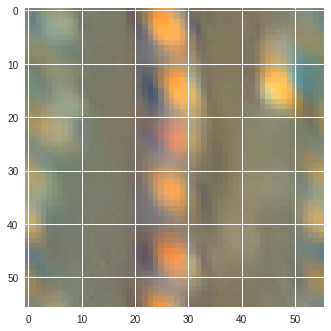

In [0]:
from vis.input_modifiers import Jitter

# layer_idx = utils.find_layer_idx(dense_f_model, 'preds')
layer_idx = -1
# Swap softmax with linear
dense_f_model.layers[layer_idx].activation = activations.linear
dense_f_model = utils.apply_modifications(dense_f_model)

# This is the output node we want to maximize.
filter_idx = 0
img1 = visualize_activation(dense_f_model, layer_idx, filter_indices=filter_idx, max_iter=500, input_modifiers=[Jitter(16)], verbose=True)
plt.imshow(img1)

Unfortunately the result is a bit disappointing. An other interesting visualization is to see the pixels most responsible for class membership.

Using phash library i find out similar images in the dataset which have different labels

In [ ]:
def find_similar_images(userpath, hashfunc = imagehash.average_hash):
    import os
    def is_image(filename):
        f = filename.lower()
        return f.endswith(".png") or f.endswith(".jpg") or \
            f.endswith(".jpeg") or f.endswith(".bmp") or f.endswith(".gif")
    
    image_filenames = [os.path.join(userpath, path) for path in os.listdir(userpath) if is_image(path)]
    images = {}
    for img in sorted(image_filenames):
        hash = hashfunc(Image.open(img))
        images[hash] = images.get(hash, []) + [img]
    
    for k, img_list in images.iteritems():
        if len(img_list) > 1:
            print(" ".join(img_list))

In [ ]:
duplicates = []
for k, img_list in images.items():
    if len(img_list) > 1 and np.sum([train_images_label[i] for i in img_list])==1:
        duplicates.append(img_list)

In [ ]:
l = [x for l in duplicates for x in l]

In [14]:
l

[14110, 55579, 23598, 25759, 24878, 27033, 31409, 31535, 75583, 115081]

In [0]:
# layer_idx = utils.find_layer_idx(dense_f_model, 'fc1000')

# f, ax = plt.subplots(4, 4)
grads_=[]
for i, img in enumerate(train_images_data.reshape(-1,56,56,3)[l]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads_.append(visualize_saliency(dense_f_model, -1, filter_indices=[0], seed_input=img))
    
    # visualize grads as heatmap
#     ax[i].imshow(grads, cmap='jet')


In [0]:
import pickle
with open('gradient2.pkl', 'wb') as f:
    pickle.dump(grads_, f)

In [0]:
from vis.visualization import overlay

In [0]:
import matplotlib.cm as cm

In [0]:
predictions = dense_f_model.predict(train_images_data.reshape(-1,56,56,3)[l])

In [0]:
predictions

array([[0.73306566, 0.26693437],
       [0.7366736 , 0.26332644],
       [0.4371795 , 0.56282043],
       [0.33011517, 0.66988486],
       [0.97543913, 0.02456084],
       [0.97543913, 0.02456084],
       [0.46679708, 0.53320295],
       [0.8726703 , 0.12732972],
       [0.11572934, 0.88427067],
       [0.08852109, 0.9114789 ]], dtype=float32)

In [0]:
labels[l]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [0]:
np.argmax(predictions, axis=1)

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1])

Only the penultimate image is well predicted, so let's visualize it.

In [0]:
diff = [train_images_data.reshape(-1,56,56,3)[i]-train_images_data.reshape(-1,56,56,3)[j] for i,j in zip(l[::2], l[1::2])]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


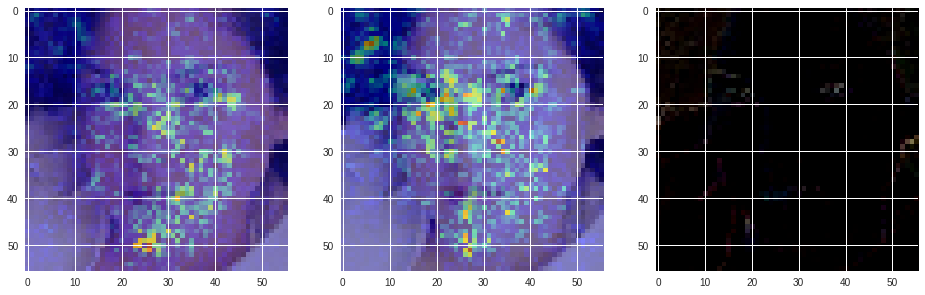

In [0]:
fig = plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(overlays[6].astype(np.float32))
plt.subplot(1,3,2)
plt.imshow(overlays[7].astype(np.float32))
plt.subplot(1,3,3)
plt.imshow(diff[3].astype(np.float32))
plt.show()

If we change the orange pixels, the image may be label as the other class. 

I  plot the difference between the similar images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


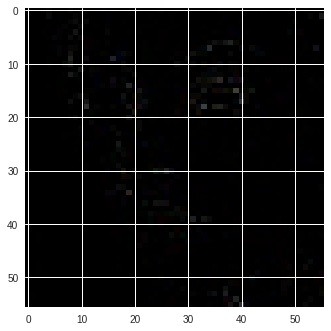

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


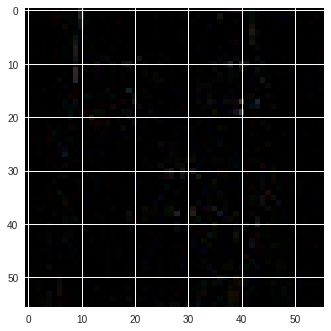

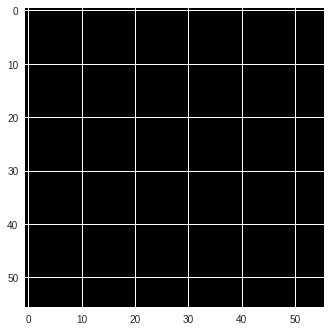

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


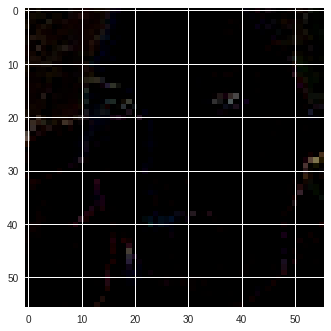

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


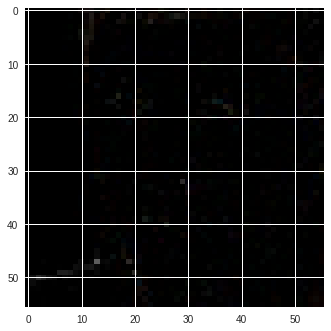

In [0]:
for i in diff:
    plt.imshow(i.astype(np.float32))
    plt.show()

In [0]:
(diff[2]==0).all()

True

The third image is exactly the same, I conclude that there are error in labeling.

And then I visualize for each duplicates the pixels the model have to pay attention to classify.

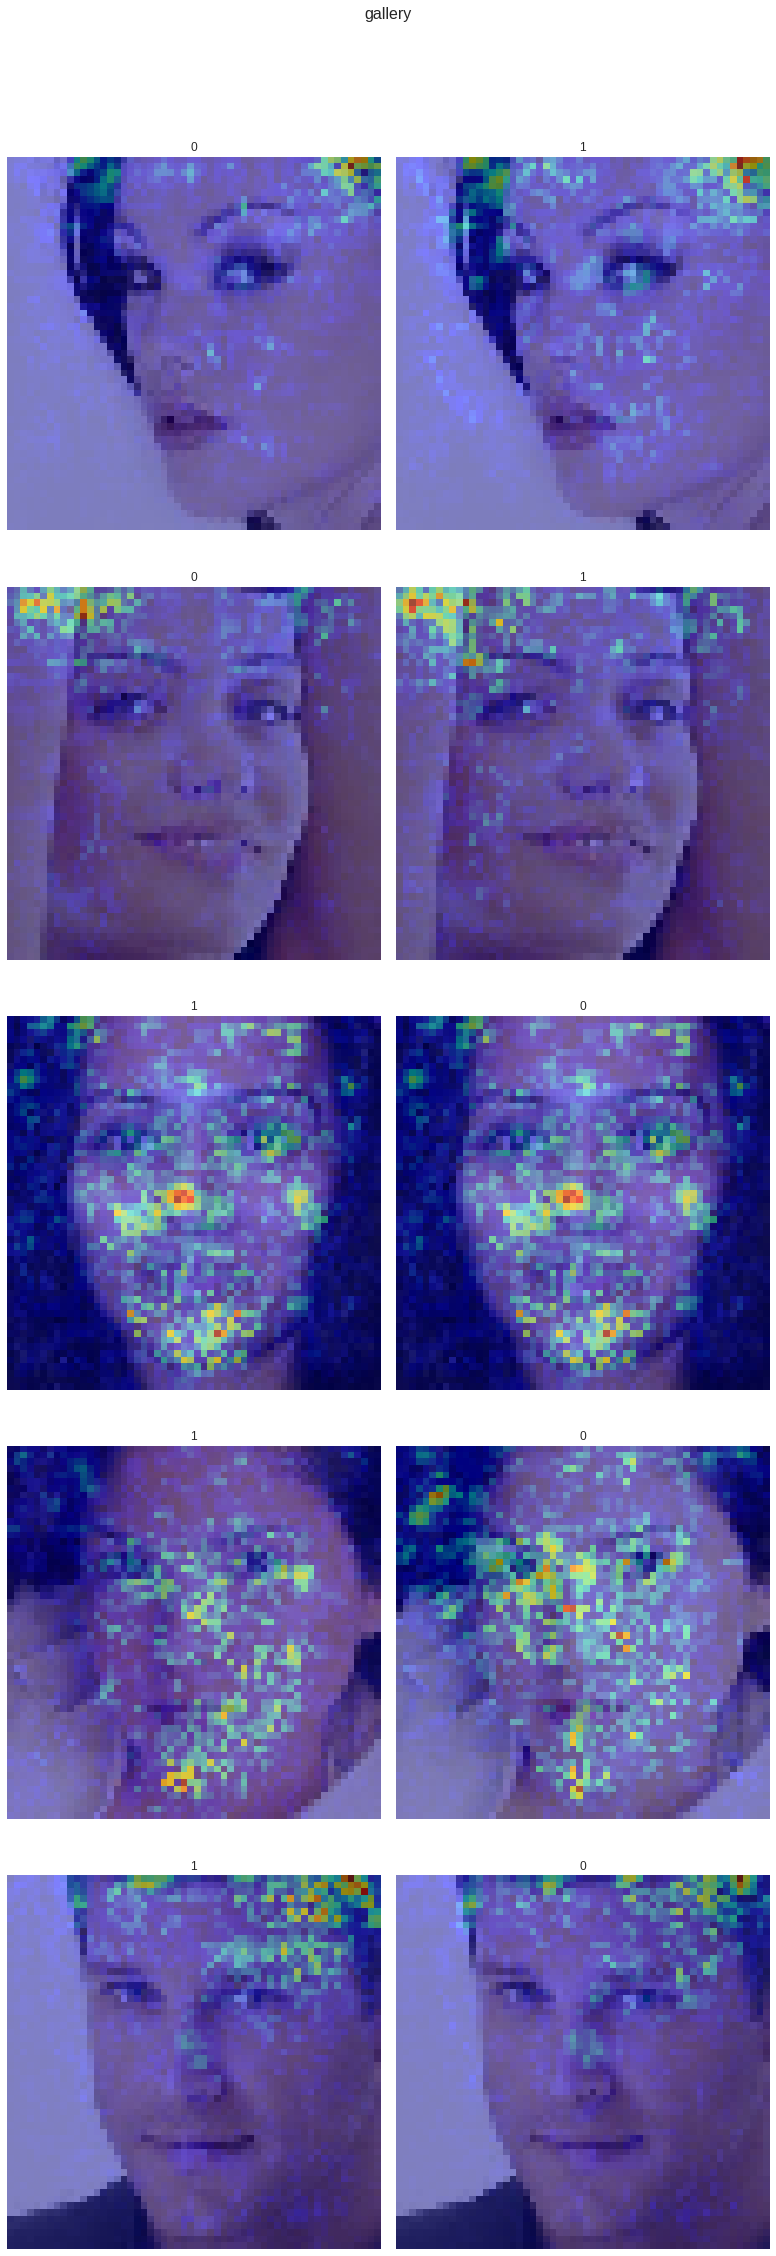

In [0]:
heatmaps = [np.float32(cm.jet(grad)[..., :3]) for grad in grads_]
overlays = [overlay(heatmap, img) for heatmap, img in zip(heatmaps, train_images_data.reshape(-1,56,56,3)[l])]
plot_gallery(overlays, train_images_label[l], image_shape=(56,56,3), n_col=2, n_row=5, size_coef=3)

I do the same for other random images.

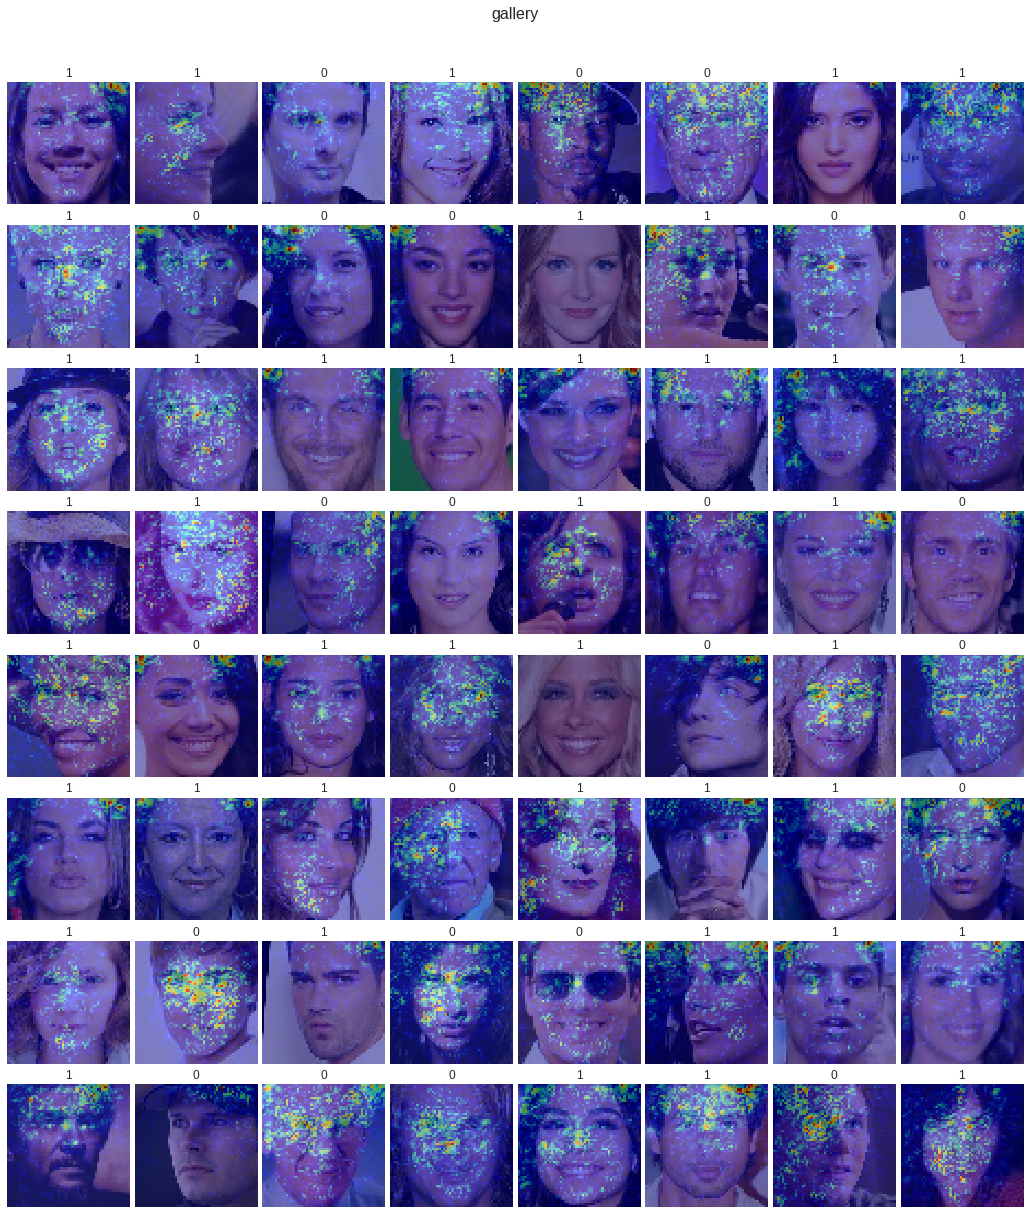

In [0]:
heatmaps = [np.float32(cm.jet(grad)[..., :3]) for grad in grads]
overlays = [overlay(heatmap, img) for heatmap, img in zip(heatmaps, train_images_data.reshape(-1,56,56,3)[:64])]
plot_gallery(overlays, train_images_label, image_shape=(56,56,3), n_row=8)

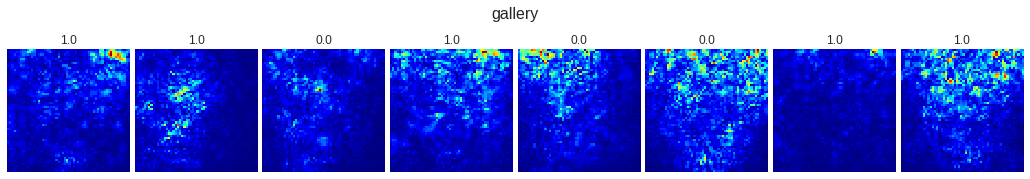

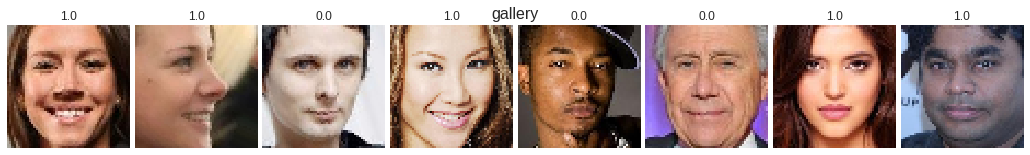

In [0]:
plot_gallery(grads, train_images_label, mycmap='jet')
plot_gallery(train_images_data.reshape(-1,56,56,3), train_images_label, n_row=1, image_shape=(56,56,3))

Unfortunately, this doesn't help me to identify the difference between 0 and 1.